<a href="https://colab.research.google.com/github/taniahdez75/st/blob/main/FeatureSelection_LastClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Features with a high % of missing values
2. Collinear (highly correlated) features
3. Features with Zero importance (based on tree models)
4. Features with LOW importance
5. Features with a single unique value

In [ ]:
import pandas as pd
import numpy as np

import lightgbm as lgb

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns

import gc

from sklearn.exceptions import NotFittedError

from itertools import chain

In [ ]:
# You can download the data from here:  https://drive.google.com/file/d/1nyQzb-5o-B7TVH06LL4XglPaxdAHbTuf/view?usp=share_link
train = pd.read_csv('/content/application_train.csv')
train = train.sample(10000)
train_labels = train['TARGET']
train.head()
train = train.drop(columns = 'TARGET')

In [ ]:
import pandas as pd
import numpy as np

import lightgbm as lgb

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import gc

from sklearn.exceptions import NotFittedError

from itertools import chain

class FeatureSelector():
    """
    Class for performing feature selection for machine learning or data preprocessing.
    
    Implements five different methods
    
        1. Remove columns with a missing percentage greater than a specified threshold
        2. Remove columns with a single unique value
        3. Remove collinear variables with a correlation greater than a specified correlation coefficient
        4. Remove features with 0.0 feature importance from a gradient boosting machine (gbm)
        5. Remove features that do not contribute to a specified cumulative feature importance from the gbm
        
    Attributes
    --------
    
    record_missing : dataframe
        Records the fraction of missing values for features with missing fraction above threshold
    
    record_single_unique : dataframe
        Records the features that have a single unique value
    
    record_collinear : dataframe
        Records the pairs of collinear variables with a correlation coefficient above the threshold
    
    record_zero_importance : dataframe
        Records the zero importance features in the data according to the gbm
    
    record_low_importance : dataframe
        Records the lowest importance features not needed to reach the threshold of cumulative importance according to the gbm
    
    feature_importances : dataframe
        All the features importances from the gbm
    
    removal_ops : dict
        Dictionary of removal operations and associated features for removal identified
        
    Notes
    --------
    
        - All 5 operations can be run with the `identify_all` method.
        - Calculating the feature importances requires labels (a supervised learning task) 
          for training the gradient boosting machine
        - For the feature importances, the dataframe is first one-hot encoded before training the gbm.
    
    """
    
    def __init__(self):
        
        # Dataframes recording information about features to remove
        self.record_missing = None
        self.record_single_unique = None
        self.record_collinear = None
        self.record_zero_importance = None
        self.record_low_importance = None
        
        self.feature_importances = None
        
        # Dictionary to hold removal operations
        self.removal_ops = {}
        
        
        
    def identify_missing(self, data, missing_threshold):
        """Find the features with a fraction of missing values above `missing_threshold`"""
        
        self.missing_threshold = missing_threshold

        # Calculate the fraction of missing in each column 
        missing_series = data.isnull().sum() / data.shape[0]
        
        self.missing_stats = pd.DataFrame(missing_series).rename(columns = {'index': 'feature', 0: 'missing_fraction'})

        # Find the columns with a missing percentage above the threshold
        record_missing = pd.DataFrame(missing_series[missing_series > missing_threshold]).reset_index().rename(columns = {'index': 'feature', 0: 'missing_fraction'})

        to_drop = list(record_missing['feature'])

        self.record_missing = record_missing
        self.removal_ops['missing'] = to_drop
        
        print('%d features with greater than %0.2f missing values.\n' % (len(self.removal_ops['missing']), self.missing_threshold))
        
    def identify_single_unique(self, data):
        """Identifies features with only a single unique value. NaNs do not count as a unique value. """

        # Calculate the unique counts in each column
        unique_counts = data.nunique()

        self.unique_stats = pd.DataFrame(unique_counts).rename(columns = {'index': 'feature', 0: 'nunique'})
        
        # Find the columns with only one unique count
        record_single_unique = pd.DataFrame(unique_counts[unique_counts == 1]).reset_index().rename(columns = {'index': 'feature', 0: 'nunique'})

        to_drop = list(record_single_unique['feature'])
    
        self.record_single_unique = record_single_unique
        self.removal_ops['single_unique'] = to_drop
        
        print('%d features with a single unique value.\n' % len(self.removal_ops['single_unique']))
    
    def identify_collinear(self, data, correlation_threshold):
        """
        Finds collinear features based on the correlation coefficient between features. 
        For each pair of features with a correlation coefficient greather than `correlation_threshold`,
        only one of the pair is identified for removal. 

        Using code adapted from: https://gist.github.com/Swarchal/e29a3a1113403710b6850590641f046c
        
        Parameters
        --------

        data : dataframe
            Data observations in the rows and features in the columns

        correlation_threshold : float between 0 and 1
            Value of the Pearson correlation cofficient for identifying correlation features

        """
        
        self.correlation_threshold = correlation_threshold

        # Calculate the correlations between every column
        corr_matrix = data.corr()
        
        self.corr_matrix = corr_matrix
    
        # Extract the upper triangle of the correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
        
        # Select the features with correlations above the threshold
        # Need to use the absolute value
        to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]
        print(to_drop)

        # Dataframe to hold correlated pairs
        record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

        # Iterate through the columns to drop
        for column in to_drop:

            # Find the correlated features
            corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

            # Find the correlated values
            corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
            drop_features = [column for _ in range(len(corr_features))]    

            # Record the information (need a temp df for now)
            temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                             'corr_feature': corr_features,
                                             'corr_value': corr_values})

            # Add to dataframe
            record_collinear = record_collinear.append(temp_df, ignore_index = True)

            
        self.record_collinear = record_collinear
        self.removal_ops['collinear'] = to_drop
        
        print('%d features with a correlation greater than %0.2f.\n' % (len(self.removal_ops['collinear']), self.correlation_threshold))

    def identify_zero_importance(self, features, labels, eval_metric, task='classification', 
                                 n_iterations=10, early_stopping = True):
        """
        
        Identify the features with zero importance according to a gradient boosting machine.
        The gbm can be trained with early stopping using a validation set to prevent overfitting. 
        The feature importances are averaged over n_iterations to reduce variance. 
        
        Uses the LightGBM implementation (http://lightgbm.readthedocs.io/en/latest/index.html)

        Parameters 
        --------
        features : dataframe
            Data for training the model with observations in the rows
            and features in the columns

        labels : array, shape = (1, )
            Array of labels for training the model. These can be either binary 
            (if task is 'classification') or continuous (if task is 'regression')

        eval_metric : string
            Evaluation metric to use for the gradient boosting machine

        task : string, default = 'classification'
            The machine learning task, either 'classification' or 'regression'

        n_iterations : int, default = 10
            Number of iterations to train the gradient boosting machine
            
        early_stopping : boolean, default = True
            Whether or not to use early stopping with a validation set when training
        
        
        Notes
        --------
        
        - Features are one-hot encoded to handle the categorical variables before training.
        - The gbm is not optimized for any particular task and might need some hyperparameter tuning
        - Feature importances, including zero importance features, can change across runs

        """

        # One hot encoding
        features = pd.get_dummies(features)

        # Extract feature names
        feature_names = list(features.columns)

        # Convert to np array
        features = np.array(features)
        labels = np.array(labels).reshape((-1, ))

        # Empty array for feature importances
        feature_importance_values = np.zeros(len(feature_names))
        
        print('Training Gradient Boosting Model\n')
        
        # Iterate through each fold
        for _ in range(n_iterations):

            if task == 'classification':
                model = lgb.LGBMClassifier(n_estimators=1000, learning_rate = 0.05, verbose = -1)

            elif task == 'regression':
                model = lgb.LGBMRegressor(n_estimators=1000, learning_rate = 0.05, verbose = -1)

            else:
                raise ValueError('Task must be either "classification" or "regression"')
                
            # If training using early stopping need a validation set
            if early_stopping:
                
                train_features, valid_features, train_labels, valid_labels = train_test_split(features, labels, test_size = 0.15)

                # Train the model with early stopping
                model.fit(train_features, train_labels, eval_metric = eval_metric,
                          eval_set = [(valid_features, valid_labels)],
                          early_stopping_rounds = 100, verbose = -1)
                
                # Clean up memory
                gc.enable()
                del train_features, train_labels, valid_features, valid_labels
                gc.collect()
                
            else:
                model.fit(features, labels)

            # Record the feature importances
            feature_importance_values += model.feature_importances_ / n_iterations

        feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

        # Sort features according to importance
        feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

        # Normalize the feature importances to add up to one
        feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
        feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])

        # Extract the features with zero importance
        record_zero_importance = feature_importances[feature_importances['importance'] == 0.0]
        
        to_drop = list(record_zero_importance['feature'])

        self.feature_importances = feature_importances
        self.record_zero_importance = record_zero_importance
        self.removal_ops['zero_importance'] = to_drop
        
        print('\n%d features with zero importance.\n' % len(self.removal_ops['zero_importance']))
    
    def identify_low_importance(self, cumulative_importance):
        """
        Finds the lowest importance features not needed to account for `cumulative_importance` 
        of the feature importance from the gradient boosting machine. As an example, if cumulative
        importance is set to 0.95, this will retain only the most important features needed to 
        reach 95% of the total feature importance. The identified features are those not needed.

        Parameters
        --------
        cumulative_importance : float between 0 and 1
            The fraction of cumulative importance to account for 

        """

        self.cumulative_importance = cumulative_importance
        
        # The feature importances need to be calculated before running
        if self.feature_importances is None:
            raise NotFittedError('Feature importances have not yet been determined. Call the `identify_zero_importance` method` first.')
            
        # Make sure most important features are on top
        self.feature_importances = self.feature_importances.sort_values('cumulative_importance')

        # Identify the features not needed to reach the cumulative_importance
        record_low_importance = self.feature_importances[self.feature_importances['cumulative_importance'] > cumulative_importance]

        to_drop = list(record_low_importance['feature'])

        self.record_low_importance = record_low_importance
        self.removal_ops['low_importance'] = to_drop
    
        print('%d features that do not contribute to cumulative importance of %0.2f.\n' % (len(self.removal_ops['low_importance']), self.cumulative_importance))
        
    def identify_all(self, features, labels, selection_params):
        """
        Use all five of the methods to identify features to remove.
        
        Parameters
        --------
        
        features : dataframe
            Data for training the model with observations in the rows
            and features in the columns

        labels : array, shape = (1, )
            Array of labels for training the model. These can be either binary 
            (if task is 'classification') or continuous (if task is 'regression')
            
        selection_params : dict
           Parameters to use in the five feature selection methhods.
           Params must contain the keys ['missing_threshold', 'correlation_threshold', 'eval_metric', 'task', 'cumulative_importance']
        
        """
        
        # Check for all required parameters
        for param in ['missing_threshold', 'correlation_threshold', 'eval_metric', 'task', 'cumulative_importance']:
            if param not in selection_params.keys():
                raise ValueError('%s is a required parameter for this method' % param)
        
        # Implement each of the five methods
        self.identify_missing(features, selection_params['missing_threshold'])
        self.identify_single_unique(features)
        self.identify_collinear(features, selection_params['correlation_threshold'])
        self.identify_zero_importance(features, labels, selection_params['eval_metric'], selection_params['task'])
        self.identify_low_importance(selection_params['cumulative_importance'])
        
        # Find the number of features identified to drop
        self.n_identified = len(set(list(chain(*list(self.removal_ops.values())))))
        print('%d total features out of %d identified for removal.\n' % (self.n_identified, pd.get_dummies(features).shape[1]))
        
    def check_identified(self):
        """Check the identified features before removal. Returns a set of the unique features identified."""
        
        all_identified = set(list(chain(*list(self.removal_ops.values()))))
        print('%d features identified for removal' % len(all_identified))
        
        return all_identified
        
    
    def remove(self, data, methods):
        """
        Remove the features from the data according to the specified methods.
        
        Parameters
        --------
            data : dataframe
                Dataframe with features to remove
            methods : 'all' or list of methods
                If methods == 'all', any methods that have identified features will be used
                Otherwise, only the specified methods will be used.
                Can be one of ['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance']
                
        Return
        --------
            data : dataframe
                Dataframe with identified features removed
                
        
        Notes 
        --------
            - This first one-hot encodes the categorical variables in accordance with the gradient boosting machine.
            - Check the features that will be removed before transforming data!
        
        """
        
        
        features_to_drop = []
        
        data = pd.get_dummies(data)
        
        if methods == 'all':
            
            print('{} methods have been run'.format(list(self.removal_ops.keys())))
            
            # Find the unique features to drop
            features_to_drop = set(list(chain(*list(self.removal_ops.values()))))
            
        else:
            # Iterate through the specified methods
            for method in methods:
                # Check to make sure the method has been run
                if method not in self.removal_ops.keys():
                    raise NotFittedError('%s method has not been run' % method)
                    
                # Append the features identified for removal
                else:
                    features_to_drop.append(self.removal_ops[method])
        
            # Find the unique features to drop
            features_to_drop = set(list(chain(*features_to_drop)))
            
        # Remove the features and return the data
        data = data.drop(columns = features_to_drop)
        self.removed_features = features_to_drop
        
        print('Removed %d features' % len(features_to_drop))
        return data
    
    def plot_missing2(self):
        """Histogram of missing fraction in each feature"""
        if self.record_missing is None:
            raise NotImplementedError("Missing values have not been calculated. Run `identify_missing`")
        
        self.reset_plot()
        self.missing_stats.plot.hist(color = 'red', edgecolor = 'k', figsize = (6, 4), fontsize = 14)
        plt.ylabel('Frequency', size = 18)
        plt.xlabel('Missing Fraction', size = 18); plt.title('Missing Fraction Histogram', size = 18);

    def plot_missing(self, threshold=0.0):
        """Histogram of missing fraction in each feature and print columns with missing values above threshold"""
        if self.record_missing is None:
            raise NotImplementedError("Missing values have not been calculated. Run `identify_missing`")
    
        # Extract the column names with missing fraction above threshold
        cols_above_threshold = self.missing_stats[self.missing_stats['missing_fraction'] > threshold].index.tolist()
        print(f"Columns with missing fraction above {threshold:.2f}: {cols_above_threshold}")
    
        # Plot the missing fraction histogram
        self.reset_plot()
        self.missing_stats.plot.bar(y='missing_fraction', color='red', edgecolor='k', figsize=(len(self.missing_stats), 4), fontsize=14)
        plt.xticks(rotation=90)
        plt.ylabel('Missing Fraction', size=18)
        plt.xlabel('Feature', size=18)
        plt.title('Missing Fraction Histogram', size=18);

    
    def plot_unique(self):
        """Histogram of number of unique values in each feature"""
        if self.record_single_unique is None:
            raise NotImplementedError('Unique values have not been calculated. Run `identify_single_unique`')
        
        self.reset_plot()
        self.unique_stats.plot.hist(edgecolor = 'k', figsize = (6, 4), fontsize = 14)
        plt.ylabel('Frequency', size = 18)
        plt.xlabel('Unique Values', size = 18); plt.title('Unique Values Histogram', size = 18);
        
    
    def plot_collinear(self):
        """
        Heatmap of the features with correlations above the correlated threshold in the data.
        
        Notes
        --------
            - Not all of the plotted correlations are above the threshold because this plots
            all the variables that have been idenfitied as having even one correlation above the threshold
            - The features on the x-axis are those that will be removed. The features on the y-axis
            are the correlated feature with those on the x-axis
        
        """
        
        if self.record_collinear is None:
            raise NotImplementedError('Collinear features have not been idenfitied. Run `identify_collinear`.')
        
        # Identify the correlations that were above the threshold
        corr_matrix_plot = self.corr_matrix.loc[list(set(self.record_collinear['corr_feature'])), 
                                                list(set(self.record_collinear['drop_feature']))]

        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(10, 8))

        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(220, 10, as_cmap=True)

        # Draw the heatmap with the mask and correct aspect ratio
        sns.heatmap(corr_matrix_plot, cmap=cmap, center=0,
                    linewidths=.25, cbar_kws={"shrink": 0.6})

        ax.set_yticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[0]))])
        ax.set_yticklabels(list(corr_matrix_plot.index), size = int(160 / corr_matrix_plot.shape[0]));

        ax.set_xticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[1]))])
        ax.set_xticklabels(list(corr_matrix_plot.columns), size = int(160 / corr_matrix_plot.shape[1]));
        
        plt.xlabel('Features to Remove', size = 8); plt.ylabel('Correlated Feature', size = 8)
        plt.title("Correlations Above Threshold", size = 14)
        
    def plot_feature_importances(self, threshold = None):
        """
        Plots 15 most important features and the cumulative importance of features.
        If `threshold` is provided, prints the number of features needed to reach `threshold` cumulative importance.

        Parameters
        --------
        threshold : float, between 0 and 1 default = None
            Threshold for printing information about cumulative importances

        """
        
        if self.record_zero_importance is None:
            raise NotImplementedError('Feature importances have not been determined. Run `idenfity_zero_importance`')

        self.reset_plot()
        
        # Make a horizontal bar chart of feature importances
        plt.figure(figsize = (10, 6))
        ax = plt.subplot()

        # Need to reverse the index to plot most important on top
        ax.barh(list(reversed(list(self.feature_importances.index[:15]))), 
                self.feature_importances['normalized_importance'].head(15), 
                align = 'center', edgecolor = 'k')

        # Set the yticks and labels
        ax.set_yticks(list(reversed(list(self.feature_importances.index[:15]))))
        ax.set_yticklabels(self.feature_importances['feature'].head(15), size = 12)

        # Plot labeling
        plt.xlabel('Normalized Importance', size = 16); plt.title('Feature Importances', size = 18)
        plt.show()

        # Cumulative importance plot
        plt.figure(figsize = (6, 4))
        plt.plot(list(range(1, len(self.feature_importances) + 1)), self.feature_importances['cumulative_importance'], 'r-')
        plt.xlabel('Number of Features', size = 14); plt.ylabel('Cumulative Importance', size = 14); 
        plt.title('Cumulative Feature Importance', size = 16);

        if threshold:

            # Index of minimum number of features needed for cumulative importance threshold
            importance_index = np.min(np.where(self.feature_importances['cumulative_importance'] > threshold))
            plt.vlines(x = importance_index + 1, ymin = 0, ymax = 1, linestyles='--', colors = 'blue')
            plt.show()

            print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))

        
    def reset_plot(self):
        plt.rcParams = plt.rcParamsDefault

In [ ]:
fs = FeatureSelector()

41 features with greater than 0.50 missing values.

Columns with missing fraction above 0.00: ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MED

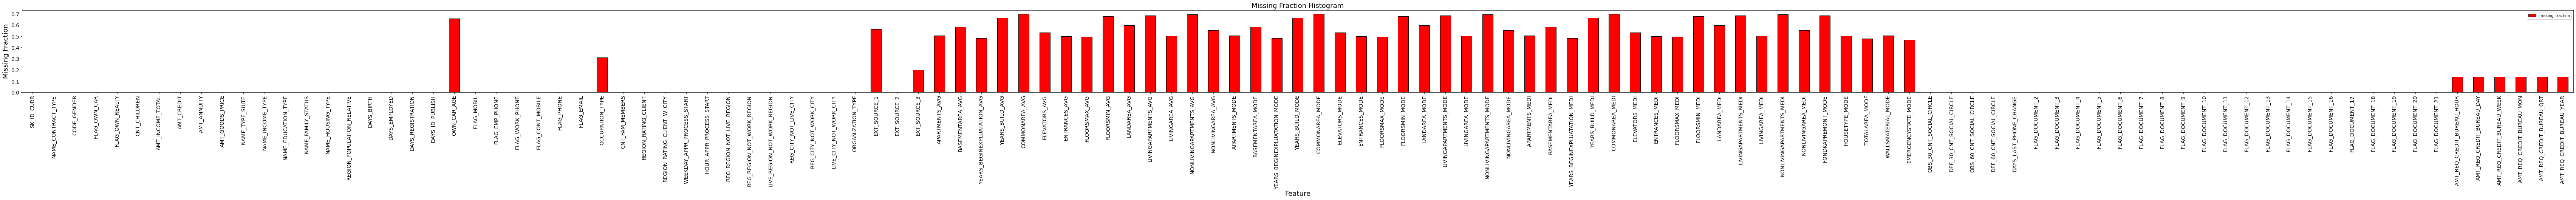

In [ ]:
fs.identify_missing(train,0.5)
fs.plot_missing()

4 features with a single unique value.



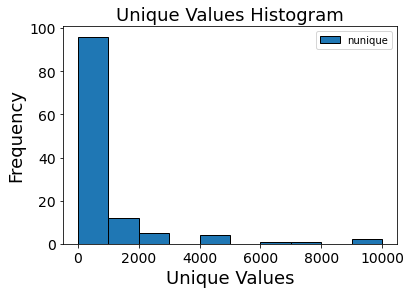

In [ ]:
fs.identify_single_unique(train)
fs.plot_unique()

<ipython-input-4-2e7bcd4280db>:144: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))


16 features with a correlation greater than 0.99.



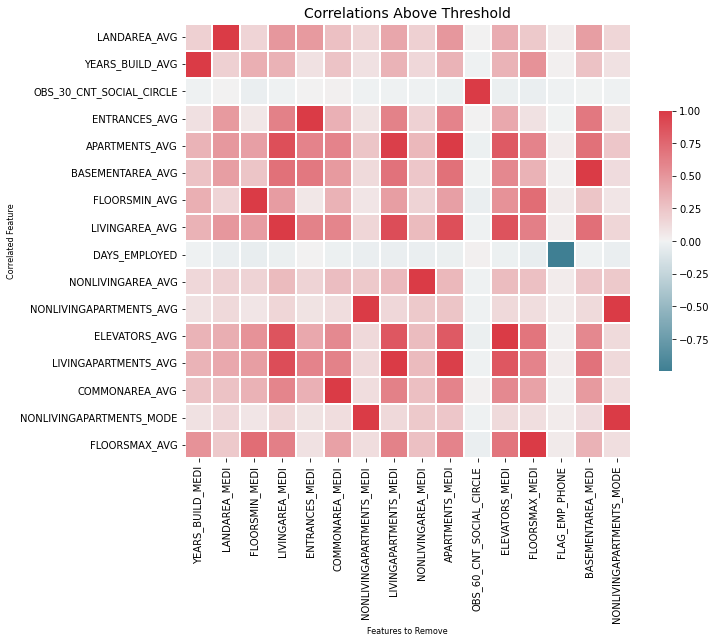

In [ ]:
fs.identify_collinear(train, 0.99)
fs.plot_collinear()

<ipython-input-4-2e7bcd4280db>:144: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))


34 features with a correlation greater than 0.90.



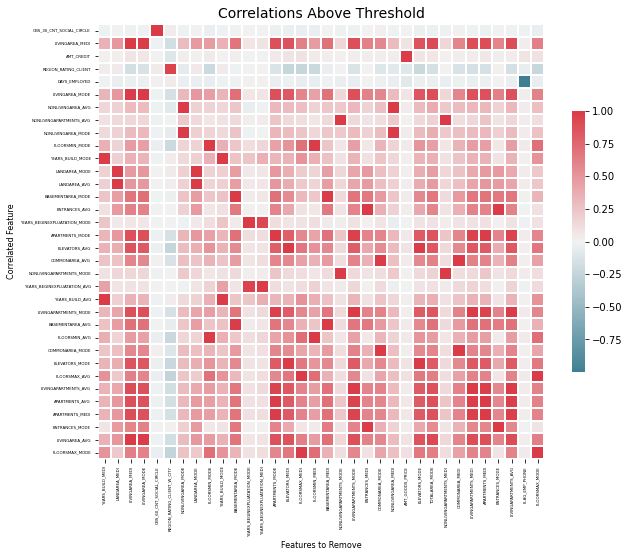

In [ ]:
fs.identify_collinear(train, 0.90)
fs.plot_collinear()

In [ ]:
fs.identify_zero_importance(train, train_labels, eval_metric='auc')

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.280985	valid_0's auc: 0.674229
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.257398	valid_0's auc: 0.700429
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.27023	valid_0's auc: 0.739019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.23498	valid_0's auc: 0.720512
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.241292	valid_0's auc: 0.724458
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.252094	valid_0's auc: 0.720

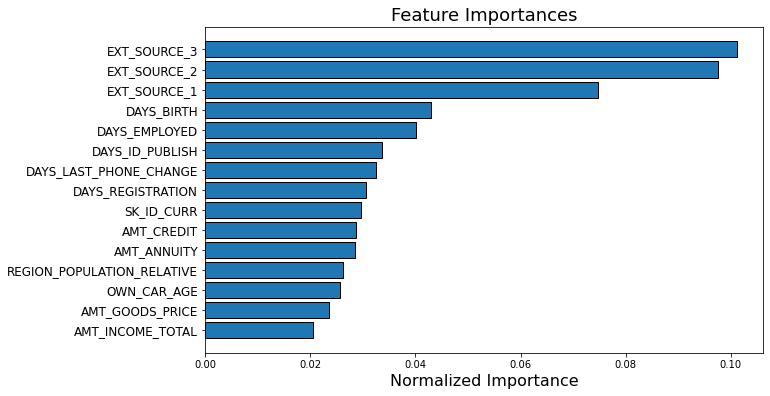

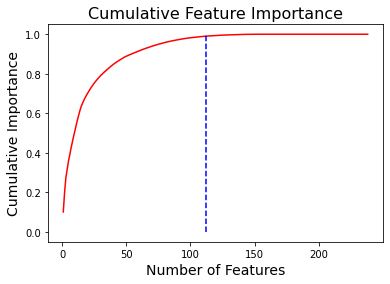

112 features required for 0.99 of cumulative importance


In [ ]:
fs.plot_feature_importances(threshold = 0.99)

In [ ]:
fs.identify_low_importance(0.99)

127 features that do not contribute to cumulative importance of 0.99.



In [ ]:
fs.identify_all(train, train_labels, {'missing_threshold': 0.9, 'correlation_threshold': 0.95, 'eval_metric': 'auc','task': 'classification', 'cumulative_importance': 0.95})

0 features with greater than 0.90 missing values.

4 features with a single unique value.



<ipython-input-4-2e7bcd4280db>:144: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))


33 features with a correlation greater than 0.95.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.246413	valid_0's auc: 0.741446
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.262217	valid_0's auc: 0.714554
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.231825	valid_0's auc: 0.771085
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.247589	valid_0's auc: 0.738152
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.256906	valid_0's auc: 0.758525
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[42]	va

In [ ]:
features_identified = fs.check_identified()

176 features identified for removal


In [ ]:
list(features_identified)[:30]

['YEARS_BUILD_MEDI',
 'FLAG_OWN_CAR_N',
 'FONDKAPREMONT_MODE_reg oper account',
 'FLAG_DOCUMENT_8',
 'FLAG_CONT_MOBILE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'REGION_RATING_CLIENT_W_CITY',
 'ORGANIZATION_TYPE_Police',
 'REG_REGION_NOT_WORK_REGION',
 'NAME_INCOME_TYPE_Pensioner',
 'WEEKDAY_APPR_PROCESS_START_FRIDAY',
 'FLAG_DOCUMENT_20',
 'EMERGENCYSTATE_MODE_No',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'NAME_HOUSING_TYPE_With parents',
 'WEEKDAY_APPR_PROCESS_START_MONDAY',
 'NAME_CONTRACT_TYPE_Revolving loans',
 'OCCUPATION_TYPE_Core staff',
 'OCCUPATION_TYPE_IT staff',
 'ORGANIZATION_TYPE_Industry: type 11',
 'ORGANIZATION_TYPE_Transport: type 1',
 'FLAG_DOCUMENT_13',
 'FLOORSMIN_MEDI',
 'ORGANIZATION_TYPE_Trade: type 5',
 'FLAG_DOCUMENT_7',
 'OCCUPATION_TYPE_Cooking staff',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'WALLSMATERIAL_MODE_Wooden',
 'WALLSMATERIAL_MODE_Block',
 'NAME_TYPE_SUITE_Other_A']

In [ ]:
train_removed = fs.remove(train, methods = 'all')

['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run
Removed 176 features


In [ ]:
train_removed.shape

(10000, 62)

In [ ]:
train_removed.to_csv('new_dataset.csv')

In [ ]:
# 9 x 8 = 73